In [21]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from google.cloud import bigquery
from pandas_gbq import read_gbq, to_gbq
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np

In [5]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/rishikeshdhokare/Documents/Ironhack/instacart-441209-84de4dcbf601.json"

### What percentage of customers have churned in the last 30 days?

In [7]:
# Create the connection to BigQuery
project_id = 'instacart-441209'
DATABASE_URI = f'bigquery://{project_id}'
engine = create_engine(DATABASE_URI)

# Query to get the max days since prior order for each user
customer_activity_query = """
SELECT user_id, MAX(days_since_prior_order) AS max_days_since_prior
FROM `instacart-441209.instacart.orders`
GROUP BY user_id
"""

# Read data into DataFrame
customer_activity_df = pd.read_sql(customer_activity_query, engine)

# Define thresholds for active and inactive customers
inactive_customers = customer_activity_df[customer_activity_df['max_days_since_prior'] >= 30]
active_customers = customer_activity_df[customer_activity_df['max_days_since_prior'] < 30]

# Count of inactive and active customers
inactive_customers_30_days_count = inactive_customers['user_id'].nunique()
active_customers_30_days_count = active_customers['user_id'].nunique()

# Query to get total number of customers
total_customers_query = """
SELECT COUNT(DISTINCT user_id) AS total_customers
FROM `instacart-441209.instacart.orders`
"""

# Get the total number of unique customers
total_customers_df = pd.read_sql(total_customers_query, engine)
total_customers = total_customers_df['total_customers'][0]

# Calculate churn rate and active rate
churn_rate_30_days = (inactive_customers_30_days_count / total_customers) * 100
active_rate_30_days = (active_customers_30_days_count / total_customers) * 100

# Print results
print(f"Total number of unique customers: {total_customers}")
print(f"Number of active customers in the last 30 days: {active_customers_30_days_count}")
print(f"Number of inactive customers in the last 30 days: {inactive_customers_30_days_count}")
print(f"Churn rate for the last 30 days: {churn_rate_30_days:.2f}%")
print(f"Active rate for the last 30 days: {active_rate_30_days:.2f}%")

/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_46084/1421610296.py:4: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pybigquery.sqlalchemy_bigquery.BigQueryDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine(DATABASE_URI)


Total number of unique customers: 206209
Number of active customers in the last 30 days: 54197
Number of inactive customers in the last 30 days: 152012
Churn rate for the last 30 days: 73.72%
Active rate for the last 30 days: 26.28%


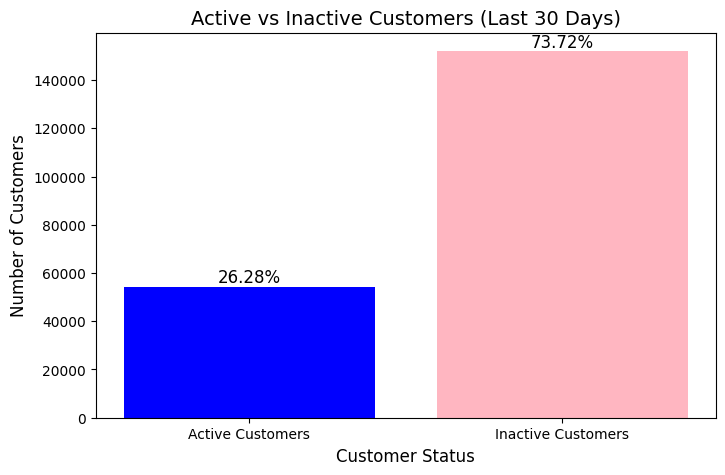

In [9]:
# Data for plotting
categories = ['Active Customers', 'Inactive Customers']
counts = [active_customers_30_days_count, inactive_customers_30_days_count]
percentages = [active_rate_30_days, churn_rate_30_days]

# Create the plot
plt.figure(figsize=(8, 5))
bars = plt.bar(categories, counts, color=['blue', 'lightpink'])

# Add titles and labels
plt.title('Active vs Inactive Customers (Last 30 Days)', fontsize=14)
plt.xlabel('Customer Status', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Add percentage annotations above the bars
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, f'{percentages[i]:.2f}%', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()

# Future churn percentages

### Feature Engineering:
We calculate days_since_last_order, which represents how many days have passed since the customer's last order.
The churned column is created by checking if the days_since_last_order is greater than the churn_threshold (30 days).

### Define feature and target

In [27]:
# Add a small constant to avoid division by zero in 'order_frequency'
customer_activity_df['order_frequency'] = 1 / (customer_activity_df['max_days_since_prior'] + 1e-5)

# Replace infinite values with a large cap
customer_activity_df['order_frequency'].replace([np.inf, -np.inf], np.nan, inplace=True)
customer_activity_df['order_frequency'].fillna(customer_activity_df['order_frequency'].max(), inplace=True)

# Define target variable 'is_churn' based on threshold
customer_activity_df['is_churn'] = customer_activity_df['max_days_since_prior'] >= 30

print(customer_activity_df.head())

   user_id  max_days_since_prior  is_churn  order_frequency
0      313                   5.0     False         0.200000
1     4978                   6.0     False         0.166666
2    25635                   6.0     False         0.166666
3    31570                   4.0     False         0.249999
4    31834                   2.0     False         0.499998


/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_46084/138638939.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_activity_df['order_frequency'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_46084/138638939.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obje

Correlation Matrix:
                       user_id  max_days_since_prior  is_churn  \
user_id               1.000000              0.002498  0.003238   
max_days_since_prior  0.002498              1.000000  0.825387   
is_churn              0.003238              0.825387  1.000000   
order_frequency       0.000383             -0.024526 -0.009059   

                      order_frequency  
user_id                      0.000383  
max_days_since_prior        -0.024526  
is_churn                    -0.009059  
order_frequency              1.000000  


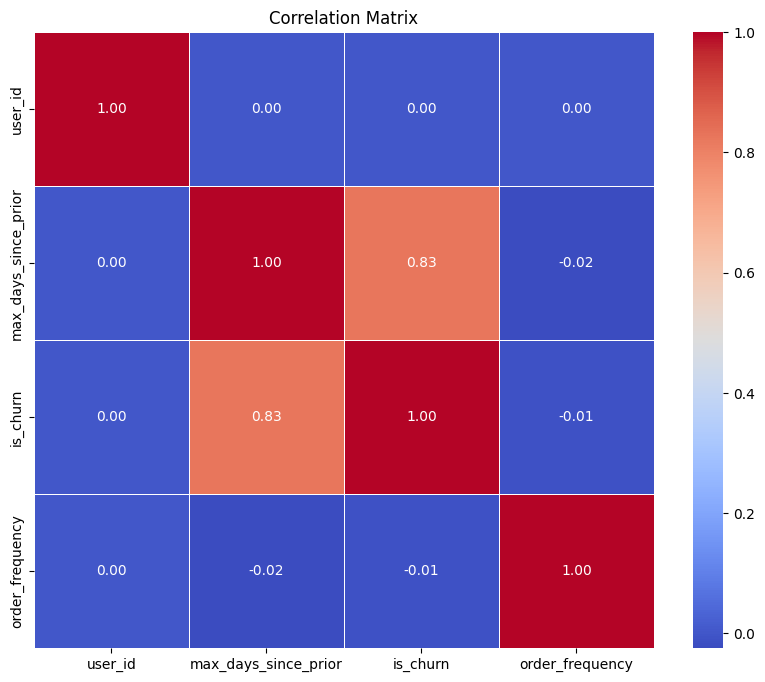

In [29]:
correlation_matrix = customer_activity_df.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix using Seaborn heatmap for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


### Modeling:

In [31]:
features = customer_activity_df[['max_days_since_prior', 'order_frequency']]  # Features with 2 variables
target = customer_activity_df['is_churn']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

### KNN Model

In [25]:
normalizer = MinMaxScaler()
normalizer.fit(X_train)

X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train_norm, y_train)

pred = knn.predict(X_test_norm)

knn_acuracy = knn.score(X_test_norm, y_test)
print("KNN Model Accuray:", knn_acuracy)

KNN Model Accuray: 1.0


### Linear Regression

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

pred = lin_reg.predict(X_test)
print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", lin_reg.score(X_test, y_test))

MAE 0.16359984268845573
RMSE 0.24833819875373306
R2 score 0.6806747876862262


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Decision Tress

In [37]:
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_norm, y_train)
pred = tree.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", tree.score(X_test_norm, y_test))

MAE 0.0
RMSE 0.0
R2 score 1.0


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Logistic Regression

In [102]:
# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict churn for the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)

# To predict churn rate for the next 30 days, we need to provide a sample with both features
# Here, we pass an example with `max_days_since_prior` = 30 and `order_frequency` = some reasonable value.
# For example, assume order_frequency = 5
predicted_churn_rate = model.predict_proba([[30, 5]])[0][1] * 100  # Predict using both features (max_days_since_prior and order_frequency)
print(f"Predicted churn rate for the next 30 days: {predicted_churn_rate:.2f}%")


Model Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Predicted churn rate for the next 30 days: 99.99%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Random Forest Classifier

In [105]:
# Initialize and train Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Predict churn on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Predict churn rate for the next 30 days based on Random Forest model
predicted_churn_prob = rf_model.predict_proba([[30, 1/30]])[0][1] * 100
print(f"Predicted churn rate for the next 30 days (Random Forest): {predicted_churn_prob:.2f}%")


Random Forest Model Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

Predicted churn rate for the next 30 days (Random Forest): 100.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Oversampling with SMOTE

In [112]:
# Initialize SMOTE and apply it to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print("Class distribution after SMOTE:", y_train_resampled.value_counts())

# Initialize and train Random Forest model on resampled data
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict churn on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Predict churn rate for the next 30 days based on Random Forest model
predicted_churn_prob = rf_model.predict_proba([[30, 1/30]])[0][1] * 100
print(f"Predicted churn rate for the next 30 days (Random Forest with SMOTE): {predicted_churn_prob:.2f}%")


Class distribution after SMOTE: is_churn
True     106328
False    106328
Name: count, dtype: int64
Random Forest Model Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

Predicted churn rate for the next 30 days (Random Forest with SMOTE): 100.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Undersampling

In [115]:
# Initialize RandomUnderSampler and apply it to the training set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print("Class distribution after undersampling:", y_train_resampled.value_counts())

# Initialize and train Random Forest model on resampled data
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict churn on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Predict churn rate for the next 30 days based on Random Forest model
predicted_churn_prob = rf_model.predict_proba([[30, 1/30]])[0][1] * 100
print(f"Predicted churn rate for the next 30 days (Random Forest with Undersampling): {predicted_churn_prob:.2f}%")


Class distribution after undersampling: is_churn
False    38018
True     38018
Name: count, dtype: int64
Random Forest Model Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

Predicted churn rate for the next 30 days (Random Forest with Undersampling): 100.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Add Cluster-Based Features

In [54]:
customer_activity_df['is_churn'] = customer_activity_df['max_days_since_prior'] >= 30

# Select features for clustering and target variable
X_clustering = customer_activity_df[['max_days_since_prior', 'order_frequency']]
y = customer_activity_df['is_churn']

# Determine the number of clusters (e.g., 3 clusters)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_activity_df['cluster'] = kmeans.fit_predict(X_clustering)

# Add the new 'cluster' feature to your main dataset
X = customer_activity_df[['max_days_since_prior', 'order_frequency', 'cluster']]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Predict churn on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Predict churn rate for the next 30 days based on Random Forest model
predicted_churn_prob = rf_model.predict_proba([[30, 1/30, 1]])[0][1] * 100
print(f"Predicted churn rate for the next 30 days (with clustering): {predicted_churn_prob:.2f}%")

Random Forest Model Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

Predicted churn rate for the next 30 days (with clustering): 72.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Gradient Boosting Regressor

In [39]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print("\nGradient Boosting Results:")
print(f'Mean Squared Error: {mse_gb:.2f}')
print(f'R^2 Score: {r2_gb:.2f}')


Gradient Boosting Results:
Mean Squared Error: 0.00
R^2 Score: 1.00


### Ada Boost Regressor

In [41]:
base_model = DecisionTreeRegressor(max_depth=3)  

ada_model = AdaBoostRegressor(estimator=base_model, n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

y_pred_ada = ada_model.predict(X_test)

mse_ada = mean_squared_error(y_test, y_pred_ada)
r2_ada = r2_score(y_test, y_pred_ada)
print("\nAdaptive Boosting Results:")
print(f'Mean Squared Error: {mse_ada:.2f}')
print(f'R^2 Score: {r2_ada:.2f}')


Adaptive Boosting Results:
Mean Squared Error: 0.00
R^2 Score: 1.00
